Symbolic h before wd: f[0]
Symbolic h after wd: f[0] + 0.5 * (-1 * f[0] + sqrt(0.1296 + f[0] ** 2))


2025-01-25 07:21:06.375 (   0.847s) [    7F53E7462140]vtkXOpenGLRenderWindow.:1290  WARN| vtkXOpenGLRenderWindow (0x3844060): bad X server connection. DISPLAY=
2025-01-25 07:21:06.426 (   0.898s) [    7F53E7462140]vtkXOpenGLRenderWindow.:1290  WARN| vtkXOpenGLRenderWindow (0x543d5c0): bad X server connection. DISPLAY=


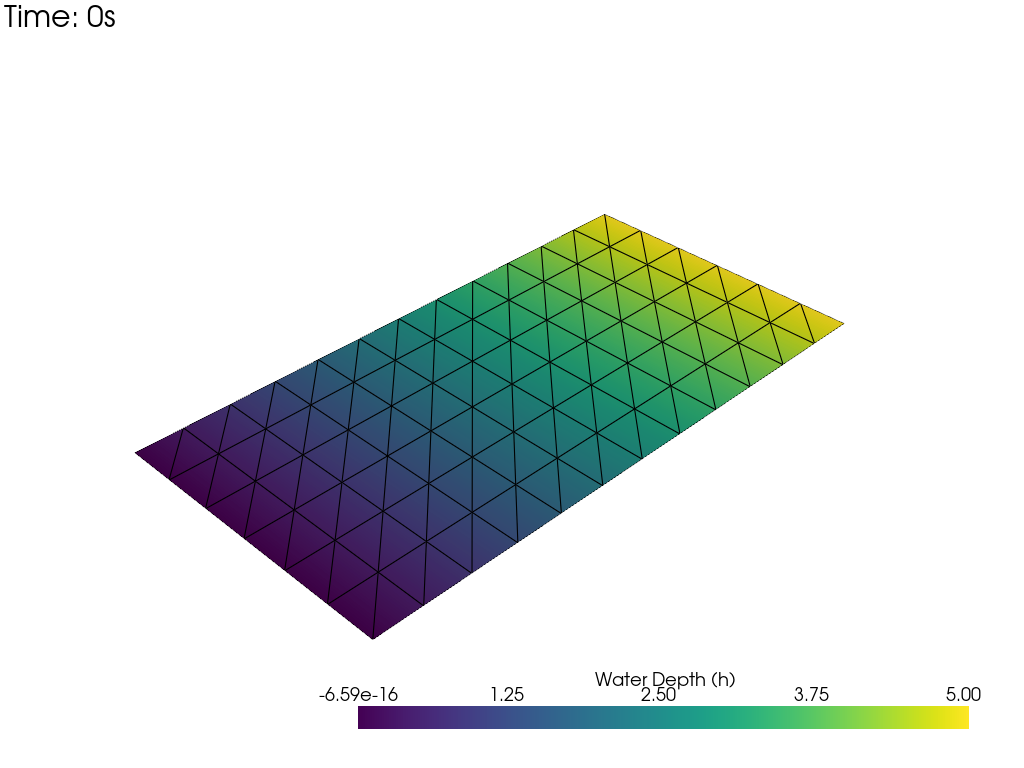

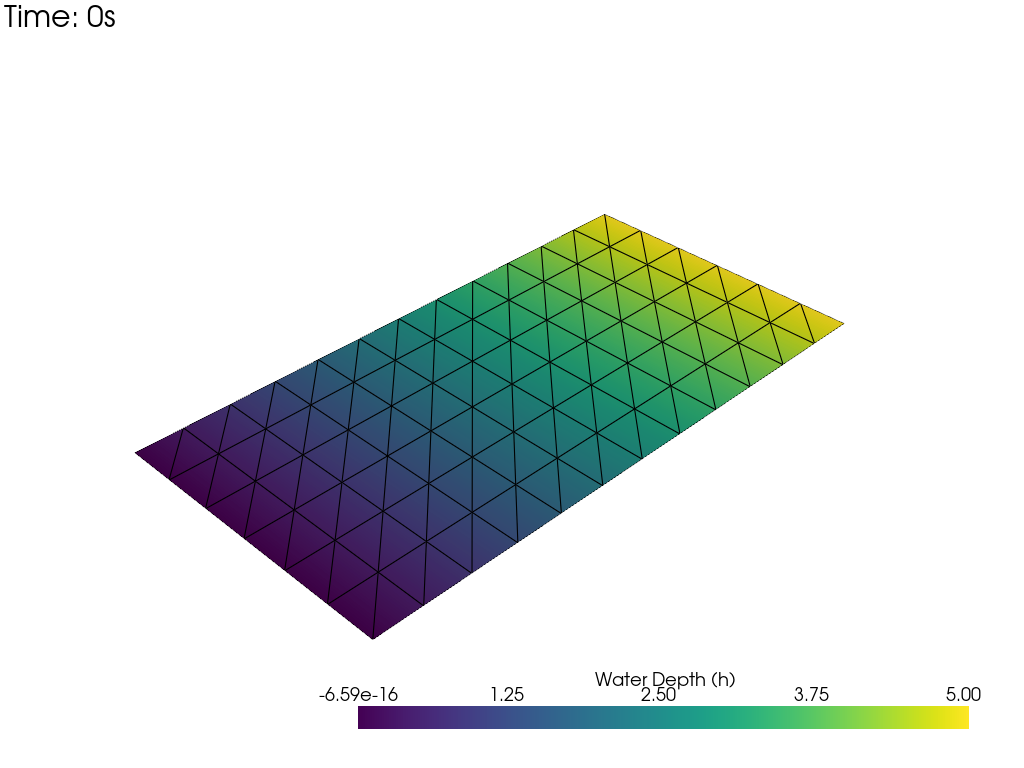

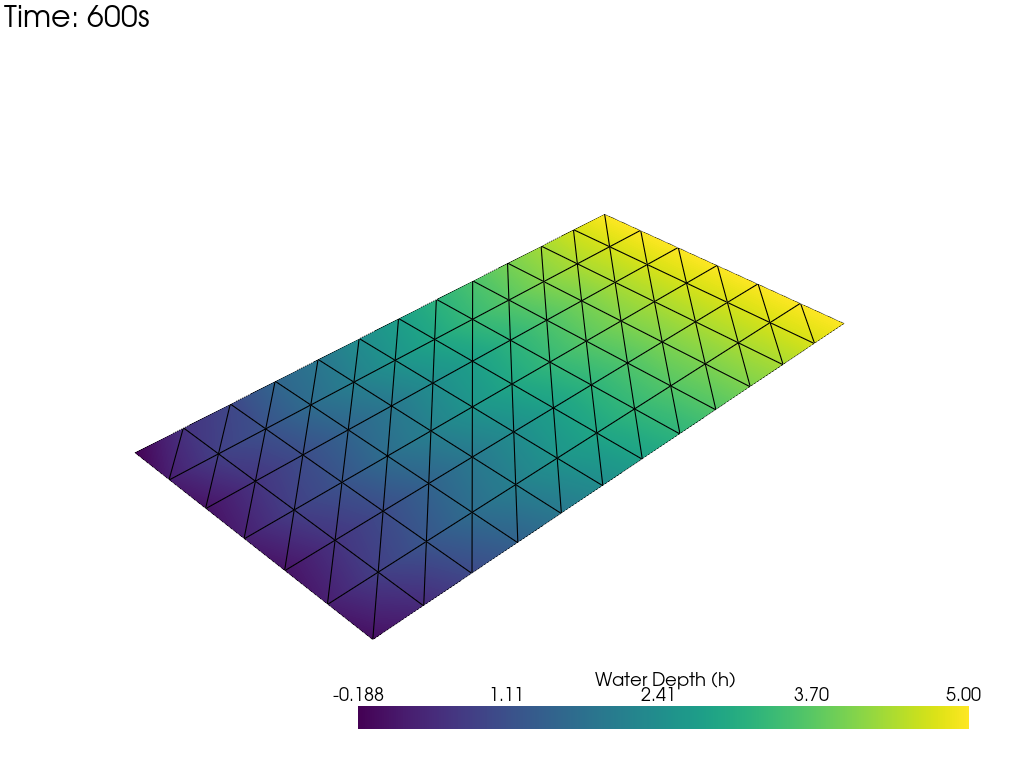

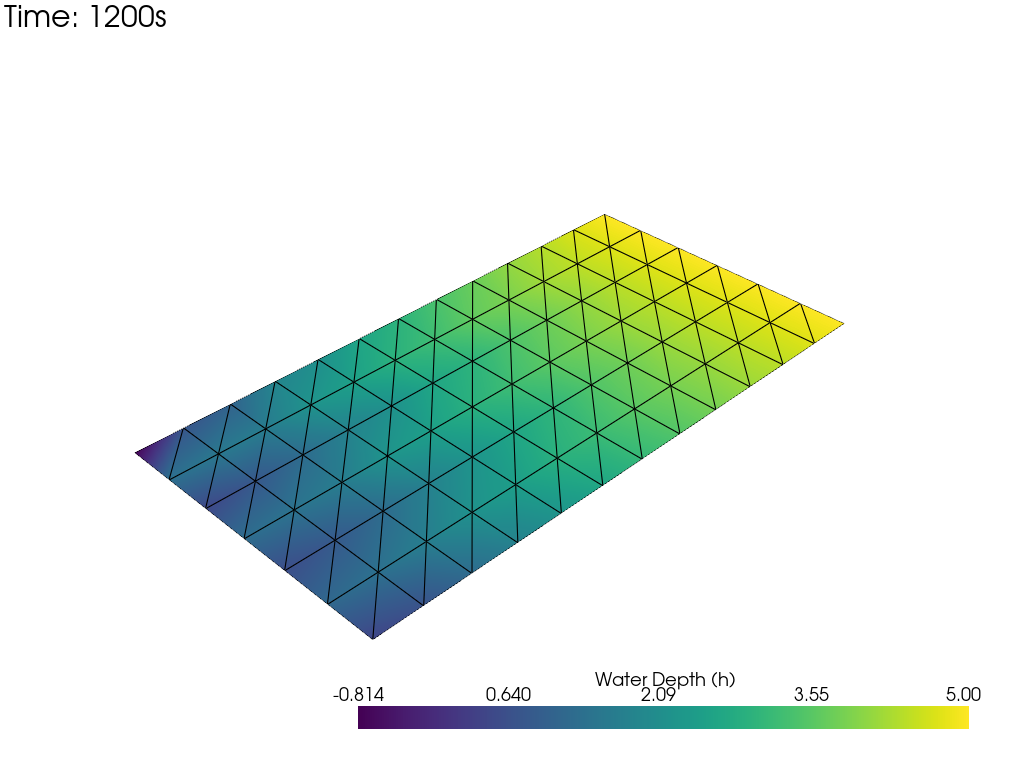

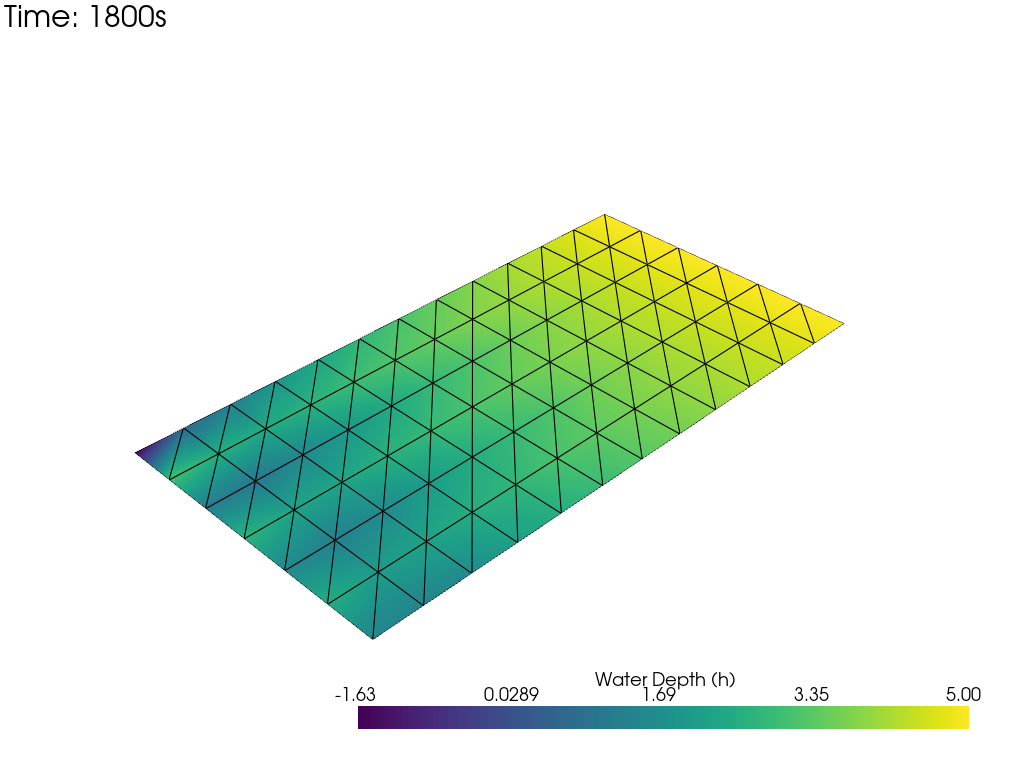

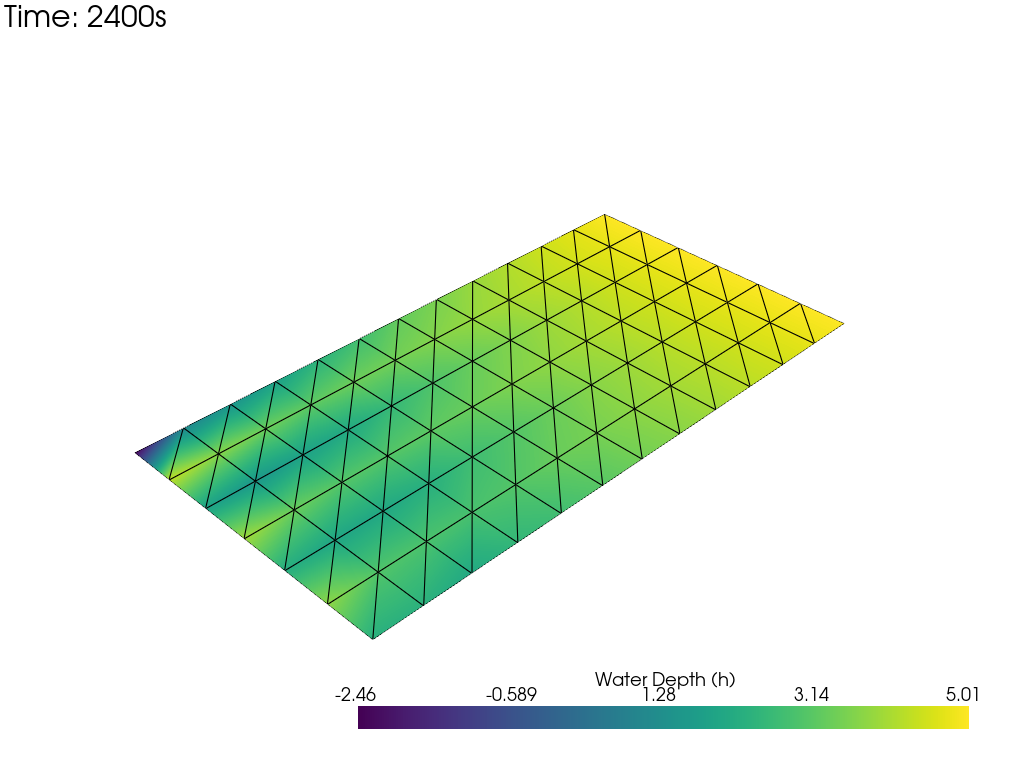

KeyboardInterrupt: 

In [1]:
# necessary importments
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem, nls, io
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.fem import locate_dofs_geometrical
from petsc4py.PETSc import ScalarType
from ufl import TrialFunction, TestFunction, div, dx
from ufl.finiteelement import FiniteElement, MixedElement
import ufl
import basix
from dolfinx.plot import vtk_mesh
import pyvista as pv
import os
import matplotlib.pyplot as plt
from dolfinx.fem import assemble_scalar
from ufl import inner, dx

# Create a directory to store frames
os.makedirs("frames", exist_ok=True)

# mesh and domain creation
Lx, Ly = 13800.0, 7200.0  
nx, ny = 12, 6           
domain = mesh.create_rectangle(
    MPI.COMM_WORLD, 
    [np.array([0.0, 0.0]), np.array([Lx, Ly])], 
    [nx, ny], 
    cell_type=mesh.CellType.triangle
)
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

# parameters and constants
g = 9.81  
n = 0.02
t, dt, T = 0.0, 600, 7*24*3600.0
num_steps = int(T / dt)

# element and functionspace
element = basix.ufl.mixed_element([basix.ufl.element("CG", str(domain.ufl_cell()), 1)] * 3)
V = fem.functionspace(domain, element)
num_subs = V.num_sub_spaces

# exporting spaces and mappings to use later
spaces = []
maps = []
for i in range(num_subs):
    space_i, map_i = V.sub(i).collapse()
    spaces.append(space_i)
    maps.append(map_i)

# required current time step functions
W = fem.Function(V)  
h, ux, uy = W.split()

# creating bathymetry
V0, _ = V.sub(0).collapse()  
z = fem.Function(V0) 
z.interpolate(lambda x: 5.0 / 13800 * (13800 - x[0]))
x = domain.geometry.x
# Update the third column (z-coordinate) of the mesh geometry
x[:, 2] = z.x.array

'''
#                        Needed for DG implementation
# Interpolate the bathymetry function z at the vertices of the mesh
# z_vertex_values = np.zeros(x.shape[0])  # Create an array to store vertex values
# for i, vertex in enumerate(x):         # Loop through vertices
#     z_vertex_values[i] = 5.0 / 13800 * (13800 - vertex[0])  # Evaluate z at each vertex
print('xshp',x.shape)
# print('z.x.array',z.x.array)
print('z.x.array',z.x.array.shape)
# x[:,2] = z.x.array
print(x)
'''
# initializing h, ux, uy with all zeros as water is flat and still at time t = 0 
h.interpolate(lambda x: np.full_like(x[0], 0.0))
ux.interpolate(lambda x: np.full_like(x[0], 0.0))
uy.interpolate(lambda x: np.full_like(x[0], 0.0))

# required previous time step functions
W_prev = fem.Function(V)  
h_prev, ux_prev, uy_prev = W_prev.split()

# initializing h_prev, ux_prev, uy_prev with all zeros as water is flat and still at time t = 0 so previous also will be same as an asumption
h_prev.interpolate(lambda x: np.full_like(x[0], 0.0))
ux_prev.interpolate(lambda x: np.full_like(x[0], 0.0))
uy_prev.interpolate(lambda x: np.full_like(x[0], 0.0))

# wetting-drying correction due to unstable solutions in the dry area
wd_alpha = 0.36
wd_alpha_sq = ScalarType(wd_alpha**2)
def wd_correction(h, alpha_sq):
    """Compute correction to water column height for wetting-and-drying."""
    return 0.5 * (ufl.sqrt(h**2 + alpha_sq) - h)

# creating trial and test functions for the weak formulation
U = TrialFunction(V)
V_test = TestFunction(V)

# The Weak Form:
def weak_form(U, U_prev, V_test, wd=True):
    h, ux, uy = U
    h_prev, ux_prev, uy_prev = U_prev
    v_h, v_ux, v_uy = V_test
    print("Symbolic h before wd:", h)
    if wd:
        h_corrected = h + wd_correction(h, wd_alpha_sq)
    else:
        h_corrected = h
    print("Symbolic h after wd:", h_corrected)
    continuity = (h - h_prev) / dt * v_h * dx + \
                 (((h+z) * ux).dx(0) * v_h + ((h+z) * uy).dx(1) * v_h) * dx
    momentum_x = (ux - ux_prev) / dt * v_ux * dx + \
                 g * (h+z) * (h+z).dx(0) * v_ux * dx + \
                 g * h * z.dx(0) * v_ux * dx + \
                 g * n**2 * ((abs(ux) * ux) / h_corrected**(1/3)) * v_ux * dx
    momentum_y = (uy - uy_prev) / dt * v_uy * dx + \
                 g * (h+z) * (h+z).dx(1) * v_uy * dx + \
                 g * h * z.dx(1) * v_uy * dx + \
                 g * n**2 * ((abs(uy) * uy) / h_corrected**(1/3)) * v_uy * dx
    return continuity + momentum_x + momentum_y

# getting spaces for bcs
V0, _ = V.sub(0).collapse()
V1, _ = V.sub(1).collapse()
V2, _ = V.sub(2).collapse()

# open(left) and wall(other) boundaries
def left_boundary(x):
    return np.isclose(x[0], 0)
def other_boundaries(x):
    return np.logical_not(np.isclose(x[0], 0)) | np.isclose(x[1], 0) | np.isclose(x[1], Ly)

# corr. facets of the boundaries
boundary_facets_left = mesh.locate_entities_boundary(domain, domain.topology.dim - 1, left_boundary)
boundary_facets_others = mesh.locate_entities_boundary(domain, domain.topology.dim - 1, other_boundaries)

# initialization of tidal value for the tide on the left(open) boundary
tidal_value = fem.Constant(domain, ScalarType(0.0))

# function for updating the tidal value dynamically in the time loop at each time
def update_tidal_value(t):
    tidal_value.value = (
        np.tanh(2.0 * t / (86400.0 * 2.0)) * 2.0 * np.cos(t * (2.0 * np.pi / (12.0 * 60 * 60)) - (90 * np.pi / 180))
    )
# Initialize tidal_value at t=0
update_tidal_value(t=0.0)

# creating dirichlet bcs for the wall and open boundaries
sub_dofs_h_left = fem.locate_dofs_topological(V.sub(0), domain.topology.dim - 1, boundary_facets_left)
bc_h_left = fem.dirichletbc(tidal_value, sub_dofs_h_left, V.sub(0))
sub_dofs_ux_others = fem.locate_dofs_topological(V.sub(1), domain.topology.dim - 1, boundary_facets_others)
sub_dofs_uy_others = fem.locate_dofs_topological(V.sub(2), domain.topology.dim - 1, boundary_facets_others)
bc_ux_others = fem.dirichletbc(fem.Constant(domain, ScalarType(0.0)), sub_dofs_ux_others, V.sub(1))
bc_uy_others = fem.dirichletbc(fem.Constant(domain, ScalarType(0.0)), sub_dofs_uy_others, V.sub(2))
bcs = [bc_h_left, bc_ux_others, bc_uy_others]

# NonlinearProblem and the NewtonSolver set up with wd = True and bcs
problem = NonlinearProblem(weak_form(W, W_prev, V_test, wd=True), W, bcs=bcs)
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.rtol = 1e-6 
solver.atol = 1e-6  
solver.max_it = 50
solver.error_on_nonconvergence = True

# Extract cells, cell types, and points from the domain mesh using VTK utilities
cells, cell_types, points = vtk_mesh(domain)
# Create a PyVista UnstructuredGrid from the mesh data
pv_mesh = pv.UnstructuredGrid(cells, cell_types, points)
# Initialize a PyVista plotter for visualization
plotter = pv.Plotter()
# desired time steps to visualize
desired_steps = [i for i in range(0, 9000000)]
# list to store the time steps
time_steps = []

# coordinates for observation stations on the mesh (x, y positions)
station_coords = [(9000, 3650), (11000, 3650), (13500, 3650)]
# dictionary to store the nearest mesh point indices for each station
stations = {coord: None for coord in station_coords}

# nearest mesh point to each station based on Euclidean distance
for coord in station_coords:
    x_coord, y_coord = coord  # x and y coordinates of the station
    distances = np.sqrt((x[:, 0] - x_coord)**2 + (x[:, 1] - y_coord)**2)  # Calculate distances to all mesh points
    station_idx = np.argmin(distances)  # index of the closest mesh point
    stations[coord] = station_idx  # Store the index in the dictionary

# Print the indices of the nearest mesh points for each station
# print("Nearest points in the mesh for each station:", stations)

# Initialize a dictionary to store time-series data (time, h, ux, uy) for each station
time_series_data = {coord: {"time": [], "h": [], "ux": [], "uy": []} for coord in station_coords}

# Loop over all time steps
for step in range(num_steps + 1):
    t = step * dt  # Compute the current time
    time_steps.append(t)  # Store the time step
    update_tidal_value(t=t)  # Update tidal boundary values

    # If the current step is in the desired steps, prepare for visualization
    if step in desired_steps:
        # Extract values for bed elevation, water depth, and velocities
        z_values = z.x.array
        h_values = h.x.array[maps[0]]
        ux_values = ux.x.array[maps[1]]
        uy_values = uy.x.array[maps[2]]

        # Add scalar data to the PyVista mesh for visualization
        pv_mesh.point_data["Bed Elevation (z)"] = z_values
        pv_mesh.point_data["Water Depth (h)"] = h_values
        pv_mesh.point_data["Bed Elevation (z) + Water Depth (h)"] = z_values + h_values
        pv_mesh.point_data["Discharge (qx)"] = h_values * ux_values  # Compute discharge in x direction
        pv_mesh.point_data["Discharge (qy)"] = h_values * uy_values  # Compute discharge in y direction

        # Start a virtual frame buffer for rendering
        pv.start_xvfb()

        # Warp the mesh by bed elevation for a 3D effect
        warped = pv_mesh.warp_by_scalar("Bed Elevation (z)")

        # Add the warped mesh to the plotter with water depth as the color map
        plotter.add_mesh(
            warped,
            scalars="Bed Elevation (z) + Water Depth (h)",
            cmap="viridis",
            show_edges=True,
            show_scalar_bar=True,
            scalar_bar_args={"title": "Water Depth (h)"}
        )

        # Create velocity arrows for visualization
        arrow_magnitude = 0.5  # Scale factor for arrows
        arrows = np.column_stack((ux_values, uy_values, np.zeros_like(ux_values))) * arrow_magnitude

        # Add a time label to the plot
        plotter.add_text(f"Time: {t}s", position="upper_left", font_size=12)

        # show the plot        
        plotter.show()

        # Save the current frame as an image
        filename = f"frames/frame_{step:04d}.png"
        plotter.screenshot(filename)
        
        # Clear the plotter for the next frame (to avoid overwriting elements)
        plotter.clear()

    # Store time-series data for each station
    for coord, idx in stations.items():
        time_series_data[coord]["time"].append(t)
        time_series_data[coord]["h"].append(h.x.array[maps[0]][idx])  # Water depth at station
        time_series_data[coord]["ux"].append(ux.x.array[maps[1]][idx])  # x-velocity at station
        time_series_data[coord]["uy"].append(uy.x.array[maps[2]][idx])  # y-velocity at station

    # Solve the system for the current time step
    solver.solve(W)

    # Scatter the solution vector (updates distributed arrays in parallel computation)
    W.x.scatter_forward()

    # Update previous step variables for the next iteration
    h_prev.x.array[:] = h.x.array[:]
    ux_prev.x.array[:] = ux.x.array[:]
    uy_prev.x.array[:] = uy.x.array[:]

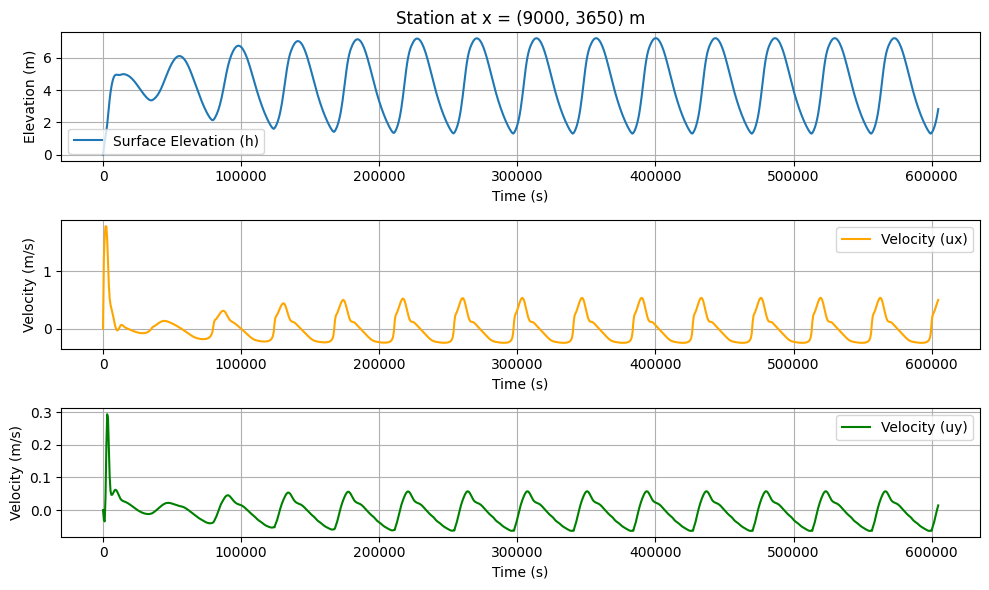

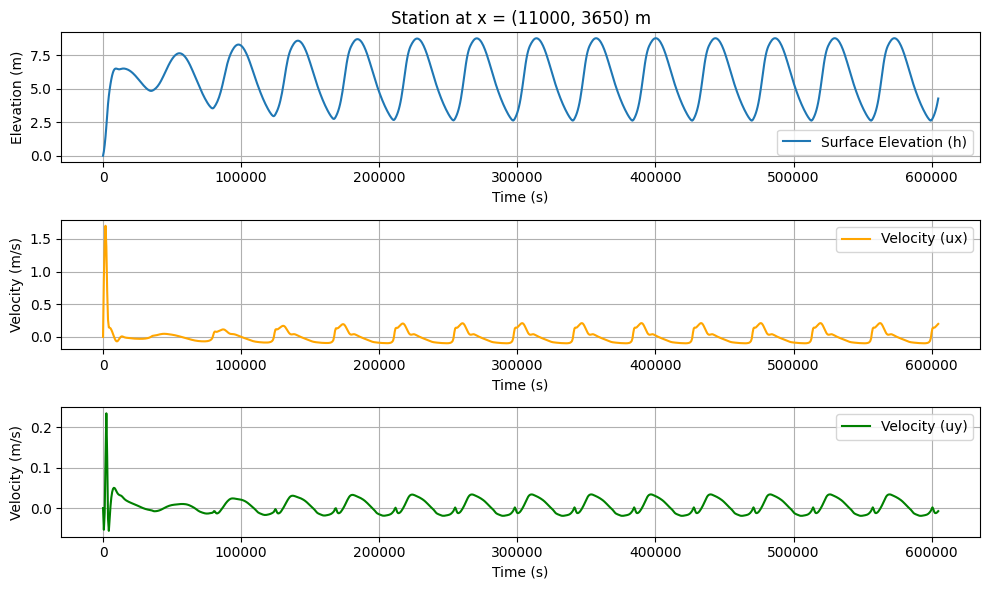

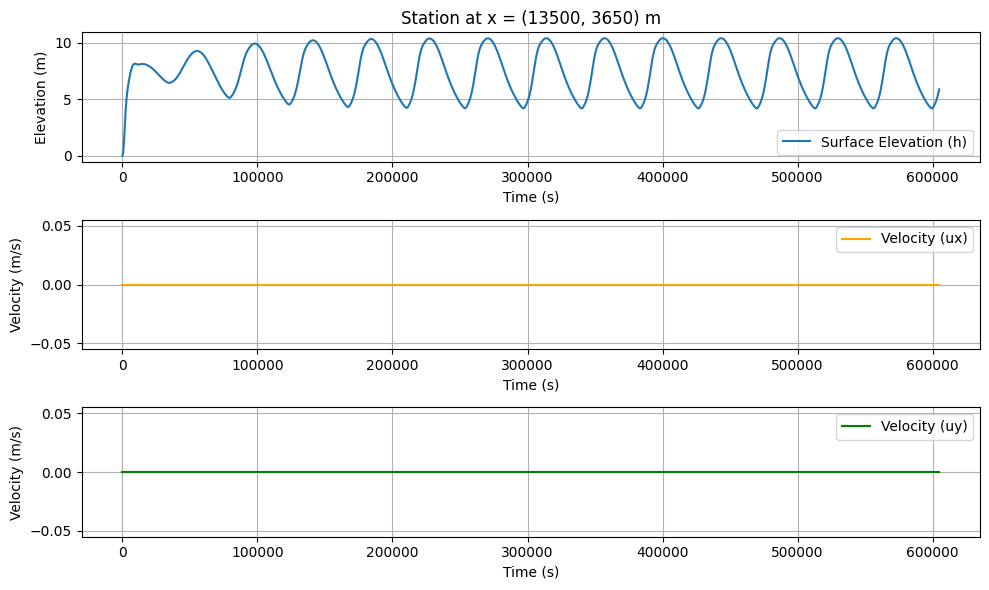

In [3]:
# plotting the station data 
import matplotlib.pyplot as plt

# Plot time series for each station
for coord in station_coords:
    plt.figure(figsize=(10, 6))

    # Plot surface elevation
    plt.subplot(3, 1, 1)
    plt.plot(time_series_data[coord]["time"], time_series_data[coord]["h"], label="Surface Elevation (h)")
    plt.title(f"Station at x = {coord} m")
    plt.xlabel("Time (s)")
    plt.ylabel("Elevation (m)")
    plt.grid()
    plt.legend()

    # Plot velocity in x-direction
    plt.subplot(3, 1, 2)
    plt.plot(time_series_data[coord]["time"], time_series_data[coord]["ux"], label="Velocity (ux)", color="orange")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid()
    plt.legend()

    # Plot velocity in y-direction
    plt.subplot(3, 1, 3)
    plt.plot(time_series_data[coord]["time"], time_series_data[coord]["uy"], label="Velocity (uy)", color="green")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"station_{coord}_timeseries.png")  # Save plot as image
    plt.show()